In [100]:
from mpl_interactions import image_segmenter

In [6]:
from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.display import show_geometry, show2D

In [4]:
ag = AcquisitionGeometry.create_Cone3D(
    source_position=[0,-255.77484131,0], detector_position=[0,855.97315869,0],
    detector_direction_x=[1,0,0], detector_direction_y=[0,0,1],
    rotation_axis_position=[0.27062218,0,0], rotation_axis_direction=[0,0,1]
    )\
    .set_panel(num_pixels=panel_num_cells,pixel_size=panel_cell_length)\
    .set_angles(angles=angles)

In [9]:
print(ag)

Please configure angular data using the set_angles() method
Please configure the panel using the set_panel() method



In [7]:
show_geometry(ag)

AttributeError: 'NoneType' object has no attribute 'num_pixels'

In [ ]:
ag.set_panel()

In [2]:
import os
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt
from cil.io import NikonDataReader, RAWFileWriter, TIFFStackReader, TIFFWriter
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector, Padder
from cil.optimisation.algorithms import CGLS, SIRT
from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry

In [18]:
base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/raw_data_3DIM/')
# path = os.path.join(base_dir,'VKH8206-X20 [2022-02-08 10.27.26]/VKH8206-X20_recon.xtekct')
# path = os.path.join(base_dir,'VKH8206-X20 [2022-02-08 10.27.26]/VKH8206-X20.xtekct')
path = os.path.join(base_dir,'VKH8206-X19 [2022-02-07 12.29.07]/VKH8206-X19.xtekct')
# path = os.path.join(base_dir,'VKH8206-X16 [2022-02-07 10.28.35]/VKH8206-X16_recon.xtekct')
reader = NikonDataReader(file_name=path)
data = reader.read()

In [22]:
print(data)
print(data.geometry)

Number of dimensions: 3
Shape: (3142, 2000, 2000)
Axis labels: ('angle', 'vertical', 'horizontal')

3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -241.69317627,    0.        ]
	Rotation axis position: [-0.,  0.,  0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ -0.        , 870.05482373,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [2000 2000]
	Pixel size: [0.2 0.2]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 3142
	Angles 0-20 in degrees:
[59.842224, 59.727623, 59.61302 , 59.49842 , 59.38382 , 59.26922 ,
 59.15461 , 59.04001 , 58.925407, 58.810806, 58.696205, 58.581604,
 58.467003, 58.3524  , 58.2378  , 58.1232  , 58.00859 , 57.89399 ,
 57.77939 , 57.664787]
Distances in units: units distance


In [23]:
# data_centre = data.get_slice(vertical='centre')

In [24]:
# base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
# file_path = os.path.join(base_dir,'centres/X19.pkl')
# with open(file_path, 'wb') as file:
#     pickle.dump(data_centre, file)

In [3]:
base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
file_path = os.path.join(base_dir,'centres/X19.pkl')
with open(file_path, 'rb') as file:
    data_centre = pickle.load(file)

FDK recon

Input Data:
	angle: 3142
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



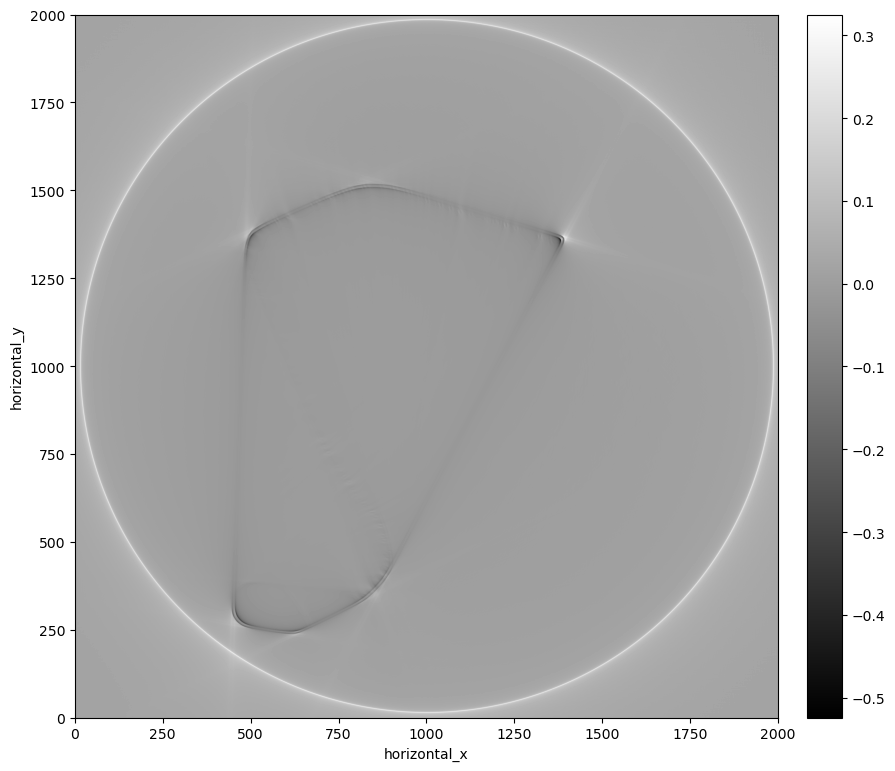

In [4]:
# data_centre = TransmissionAbsorptionConverter()(data_centre)
data_centre.reorder('tigre')
fdk = FDK(data_centre)
recon_centre = fdk.run()
show2D(recon_centre)

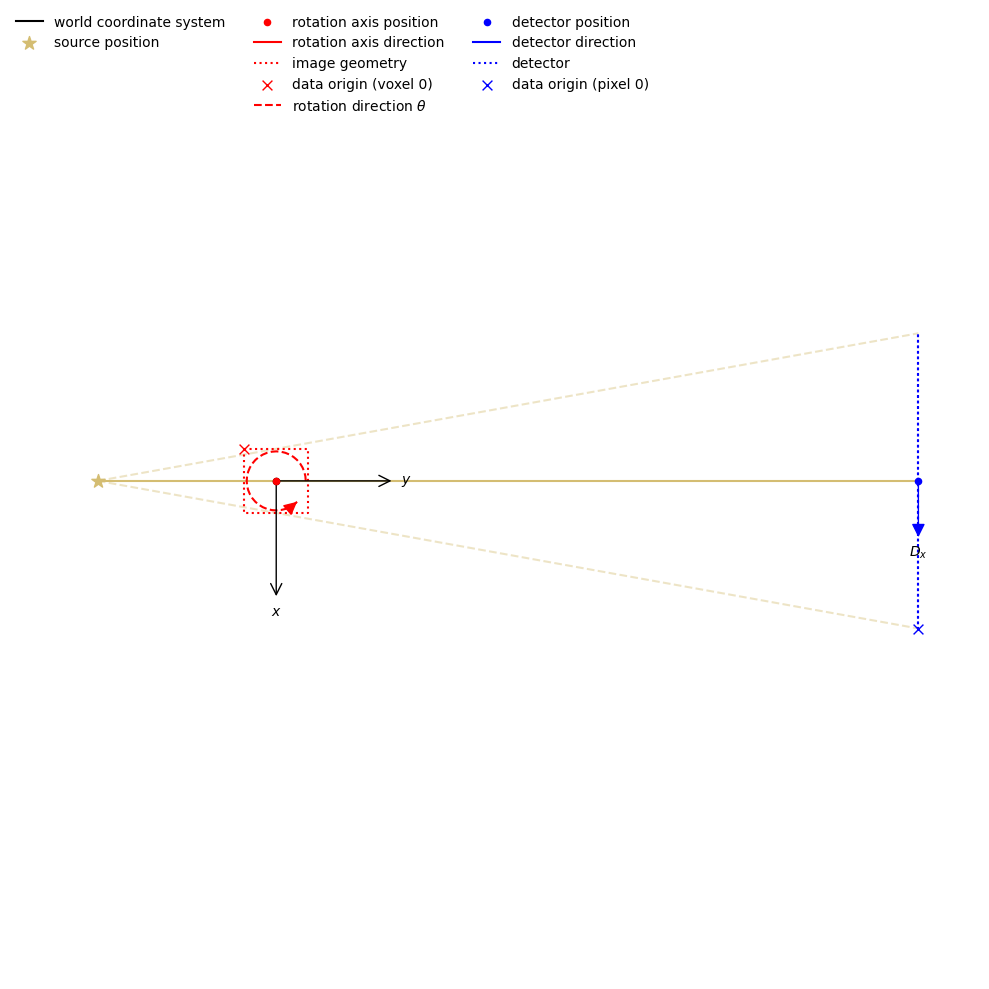

In [5]:
ag_centre = data_centre.geometry
ig_centre = ag_centre.get_ImageGeometry()
show_geometry(ag_centre,ig_centre)

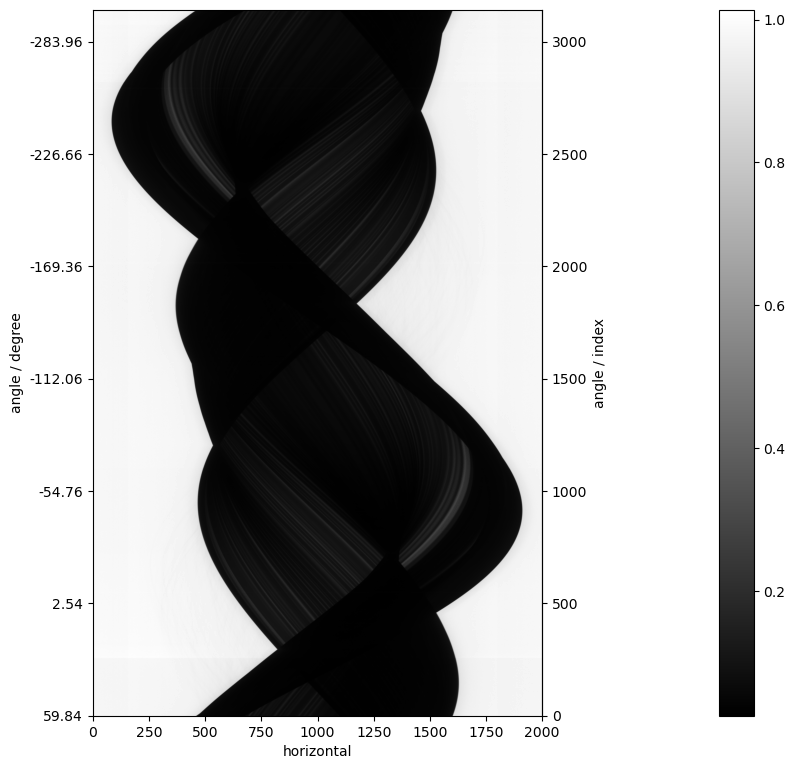

In [6]:
show2D(data_centre)

FDK recon

Input Data:
	angle: 3142
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



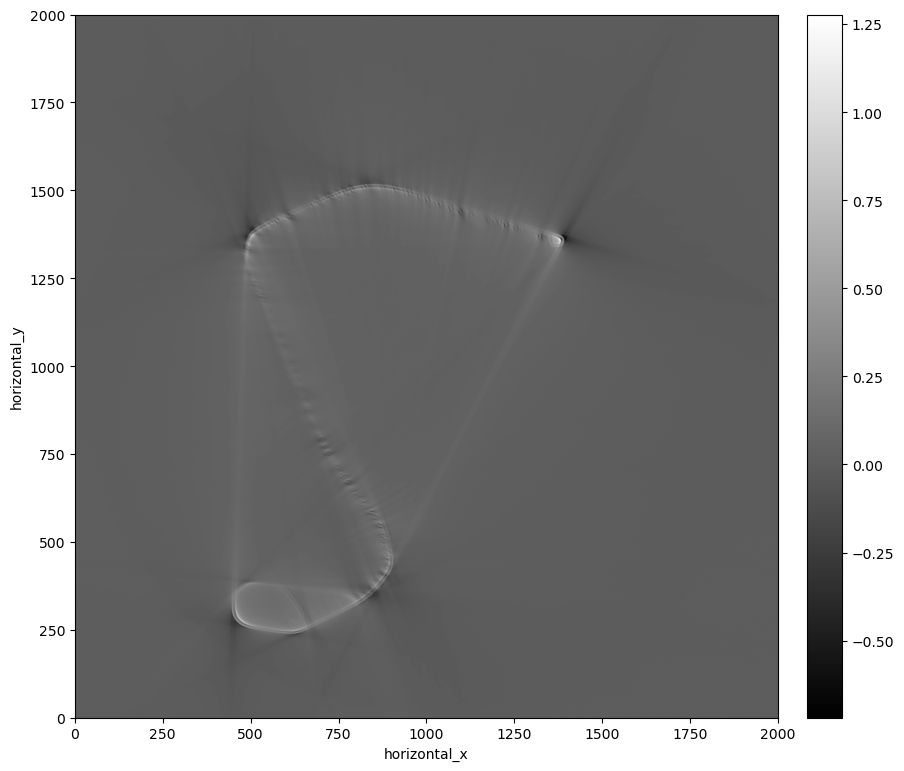

In [7]:
data2 = TransmissionAbsorptionConverter()(data_centre)
show2D(FDK(data2).run())

In [8]:
# backend='astra'
data3 = CentreOfRotationCorrector.image_sharpness()(data2)

In [9]:
data2.geometry.get_centre_of_rotation(distance_units='pixels')

{'offset': (0.0, 'pixels'), 'angle': (0.0, 'radian')}

In [10]:
data3.geometry.get_centre_of_rotation(distance_units='pixels')

{'offset': (4.254755316641101, 'pixels'), 'angle': (0.0, 'radian')}

In [12]:
# base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
# file_path = os.path.join(base_dir,'centres/X19_cor.pkl')

# with open(file_path, 'wb') as file:
#     pickle.dump(data3, file)

FDK recon

Input Data:
	angle: 3142
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



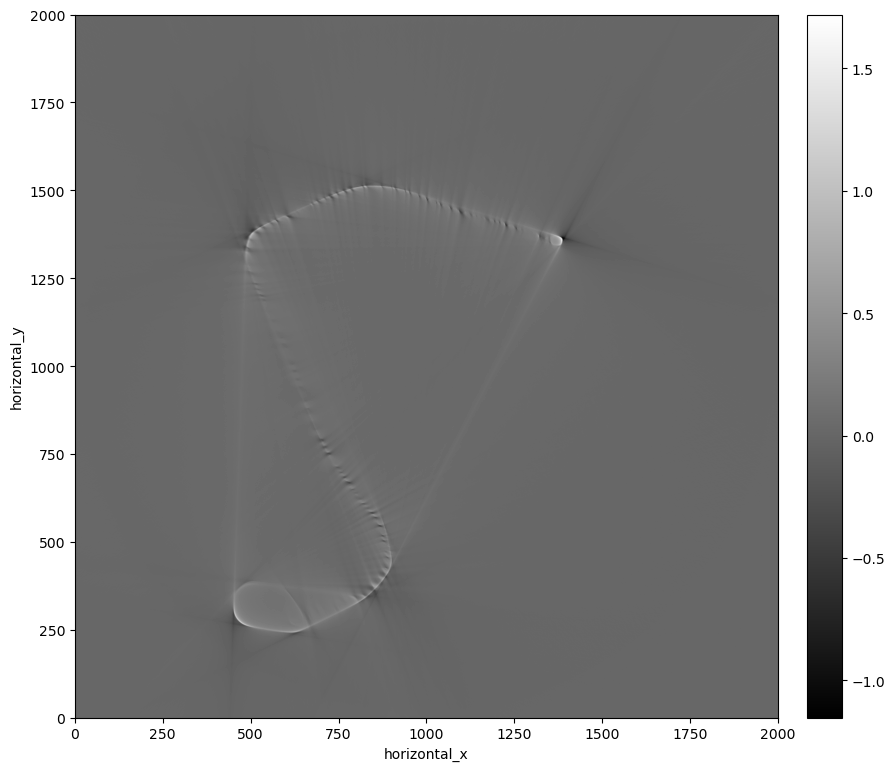

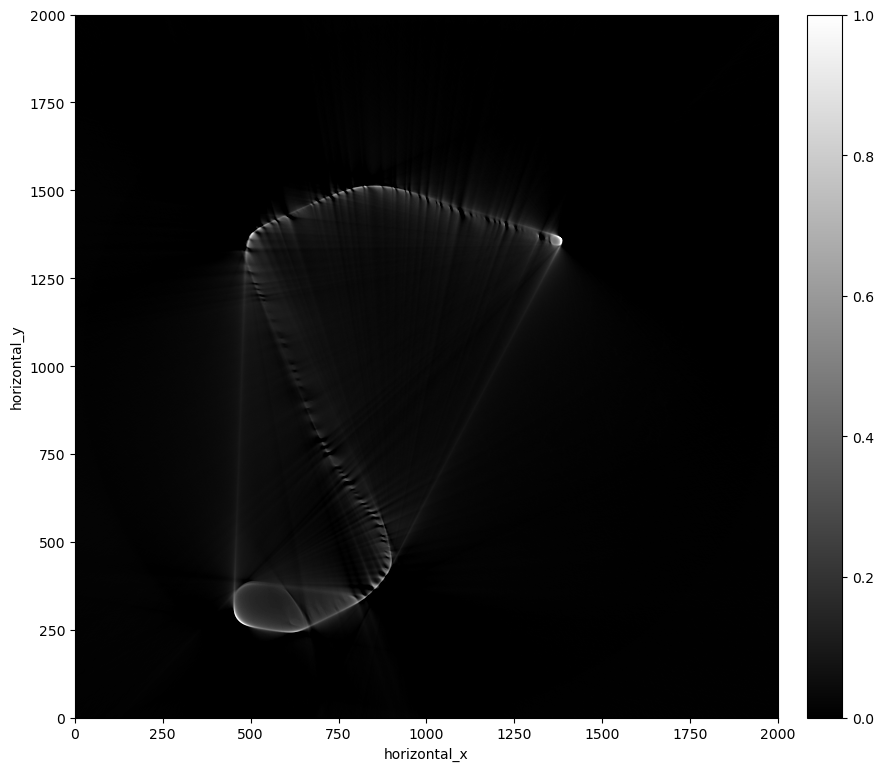

In [11]:
rec3 = FDK(data3).run()
show2D(rec3)
show2D(rec3,fix_range=(0,1))

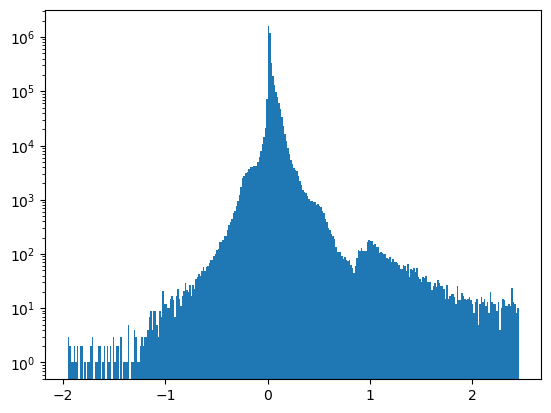

In [74]:
plt.hist(rec3.as_array().flatten(),bins=300)
plt.yscale('log')

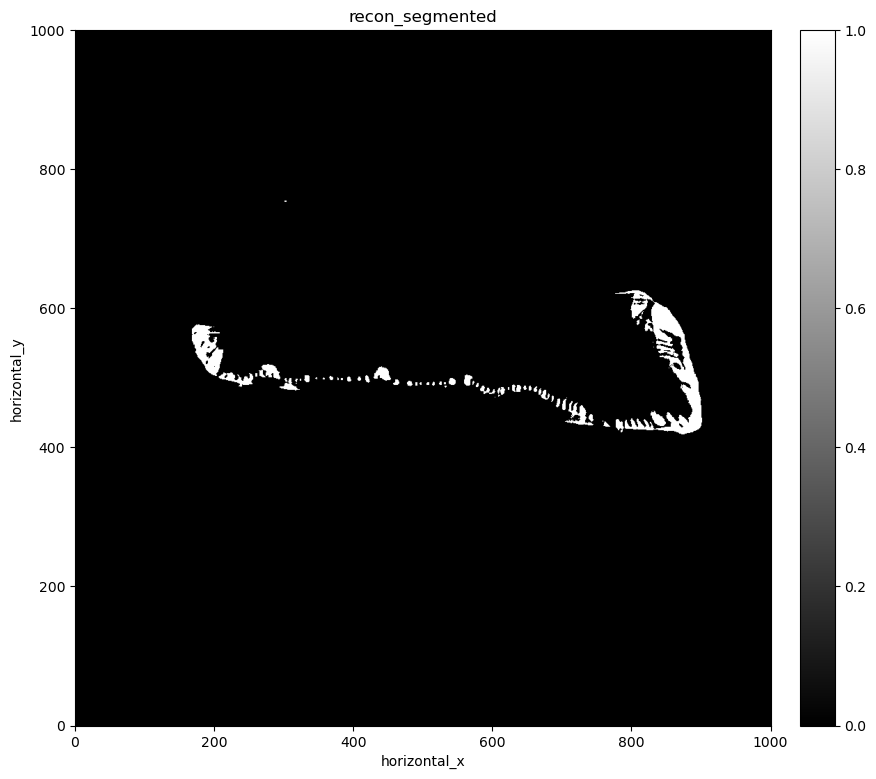

In [99]:
tau = 0.1
recon_segmented = ImageData(array=np.array(rec3 > tau,dtype='float32'), geometry=ig_centre)
show2D(recon_segmented,title='recon_segmented')

In [106]:
%matplotlib

Using matplotlib backend: <object object at 0x7faa742c2410>


In [111]:
import matplotlib

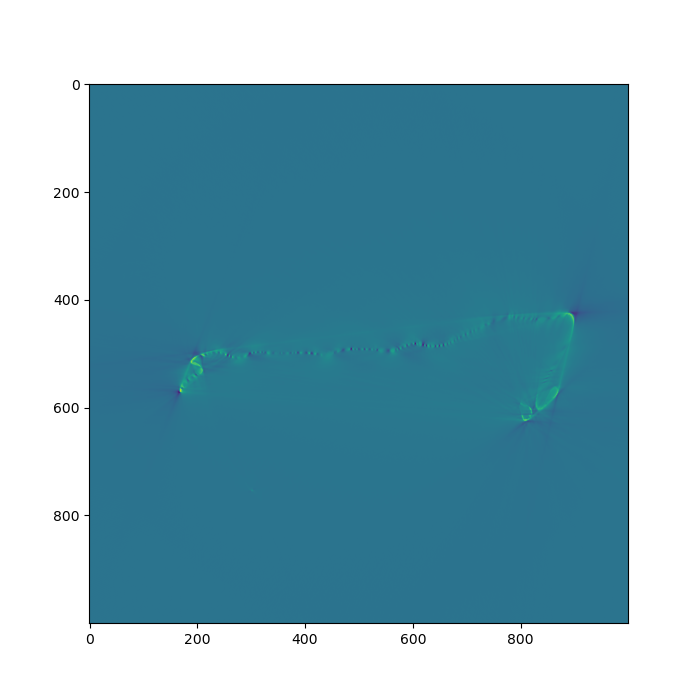

In [118]:
%matplotlib ipympl
segmenter = image_segmenter(rec3.as_array(), mask_colors="red", mask_alpha=0.76, figsize=(7, 7))
display(segmenter)

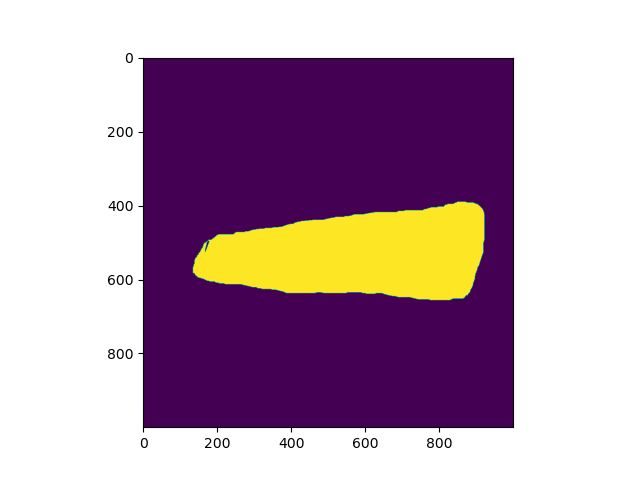

In [120]:
plt.figure()
plt.imshow(segmenter.mask)

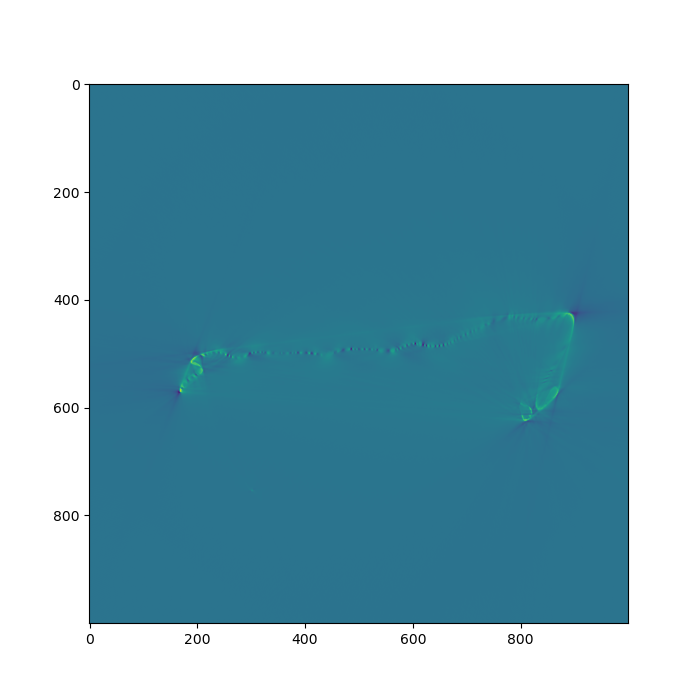

In [126]:
%matplotlib ipympl
segmenter2 = image_segmenter(rec3.as_array(), mask_colors="red", mask_alpha=0.76, figsize=(7, 7))
display(segmenter2)

In [129]:
# base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
# file_path = os.path.join(base_dir,'centres/X20_ROI.pkl')

# mask = segmenter.mask-segmenter2.mask
# with open(file_path, 'wb') as file:
#     pickle.dump(mask, file)


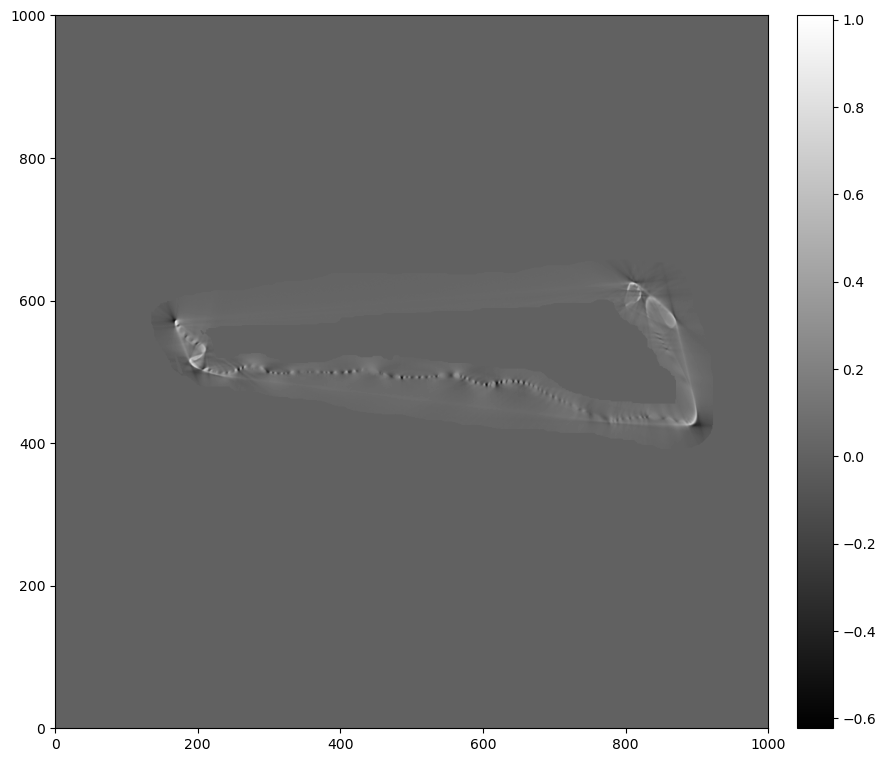

In [128]:
%matplotlib inline
show2D(rec3.as_array() * (segmenter.mask-segmenter2.mask))

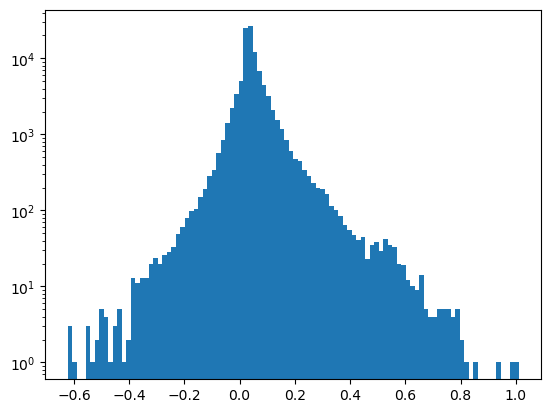

In [135]:
rec3_ROI = rec3.as_array()[np.array(mask,dtype=bool)]
plt.hist(rec3_ROI,bins=100)
plt.yscale('log')

TypeError: Invalid shape (103112,) for image data

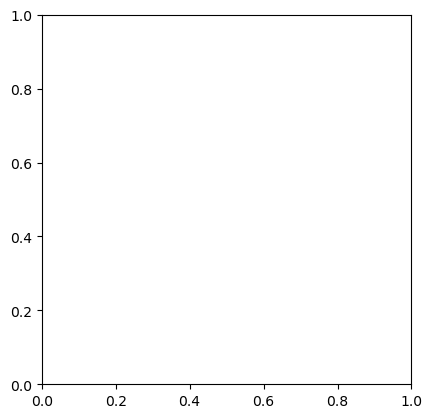

In [136]:
plt.imshow()